In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

# load data

In [2]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

# Time series split

In [3]:
x_train.columns

Index(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'Contract_1',
       'InternetService_1', 'InternetService_0'],
      dtype='object')

In [4]:
tscv = TimeSeriesSplit(n_splits=10)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=10)

# Training XgBoost model

tune num_estimators first

## tuning num_estimators

In [11]:
num_estimators_list = [50, 60, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700]

tscv_loss_dict = {}
for ix, ne in enumerate(num_estimators_list):
    print(f"num_estimators {ne}")

    tscv_loss_list = []

    for train_index, cv_index in tscv.split(x_train):

        # get data for cv ready
        x_train_req = x_train.iloc[train_index]
        x_cv_req = x_train.iloc[cv_index]

        y_train_req = y_train.iloc[train_index]
        y_cv_req = y_train.iloc[cv_index]

        # print(f"len_train {len(train_index)}, len_cv {len(cv_index)}")
        clf = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=ne,
            eval_metric="rmse",
            booster="gbtree",
        )
        clf.fit(x_train_req, y_train_req)

        # get log los train
        y_pred_train_mse = clf.predict(x_train_req)
        mse_train = mean_squared_error(y_train_req, y_pred_train_mse)
        rmse_train = mean_squared_error(y_train_req, y_pred_train_mse, squared=False)

        # get log los cv set
        y_pred_val_mse = clf.predict(x_cv_req)
        mse_cv = mean_squared_error(y_cv_req, y_pred_val_mse)
        rmse_cv = mean_squared_error(y_cv_req, y_pred_val_mse, squared=False)

        tscv_loss_list.append(
            {
                "mse_train": mse_train,
                "rmse_train": rmse_train,
                "mse_cv": mse_cv,
                "rmse_cv": rmse_cv,
            }
        )

    tscv_loss_dict[ix] = tscv_loss_list

num_estimators 50
num_estimators 60
num_estimators 70
num_estimators 100
num_estimators 150
num_estimators 200
num_estimators 250
num_estimators 300
num_estimators 400
num_estimators 500
num_estimators 600
num_estimators 700


In [12]:
df_tscv = pd.DataFrame(tscv_loss_dict.items()).rename(
    columns={0: "iteration", 1: "losses"}
)

df_tscv["mse_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["mse_train"] for i in x])
)
df_tscv["rmse_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["rmse_train"] for i in x])
)
df_tscv["mse_cv"] = df_tscv["losses"].apply(lambda x: np.mean([i["mse_cv"] for i in x]))
df_tscv["rmse_cv"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["rmse_cv"] for i in x])
)


df_tscv["num_estimators"] = num_estimators_list
df_tscv = df_tscv.drop(columns=["losses"])[
    ["iteration", "mse_train", "mse_cv", "rmse_train", "rmse_cv", "num_estimators"]
]
df_tscv

,iteration,mse_train,mse_cv,rmse_train,rmse_cv,num_estimators
0,0,0.559745,4.979653,0.728611,2.095662,50
1,1,0.472921,4.943537,0.665815,2.085913,60
2,2,0.403370,4.930776,0.611109,2.081902,70
3,3,0.278730,4.910718,0.496170,2.077276,100
4,4,0.167012,4.891378,0.373752,2.072104,150
5,5,0.109661,4.894360,0.295251,2.072682,200
6,6,0.075609,4.895737,0.239423,2.072765,250
7,7,0.053552,4.905415,0.197228,2.075876,300
8,8,0.029595,4.914172,0.141974,2.078265,400
9,9,0.016938,4.917864,0.104348,2.079398,500


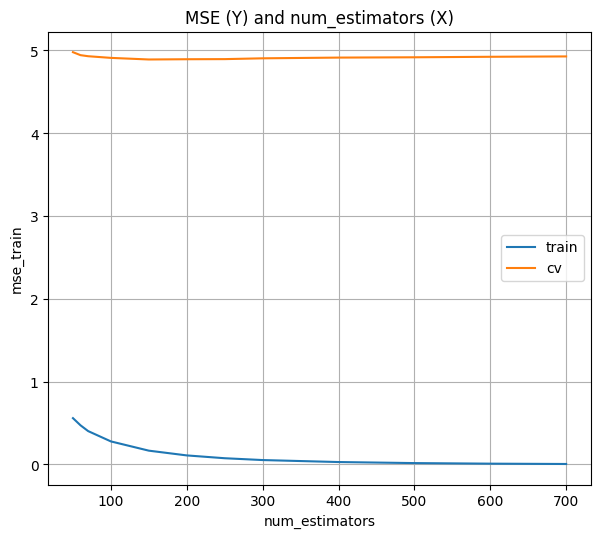

In [13]:
plt.figure(figsize=[7, 6], dpi=100)
plt.title(f"MSE (Y) and num_estimators (X)")
sns.lineplot(y="mse_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="mse_cv", x="num_estimators", data=df_tscv)

plt.legend(["train", "cv"])
plt.grid()

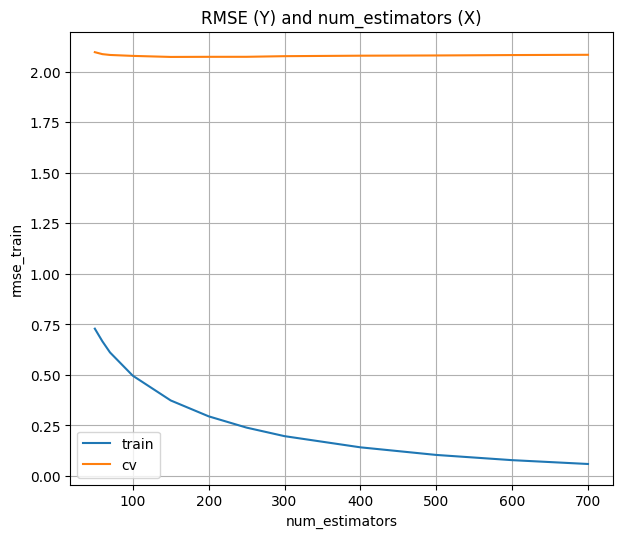

In [16]:
plt.figure(figsize=[7, 6], dpi=100)
plt.title(f"RMSE (Y) and num_estimators (X)")
sns.lineplot(y="rmse_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="rmse_cv", x="num_estimators", data=df_tscv)

plt.legend(["train", "cv"])
plt.grid()

Using `n_estimators = 400` as best param

## re-train with best num_estimators

In [17]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

In [21]:
clf = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    eval_metric="rmse",
    booster="gbtree",
)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

In [22]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test = mean_squared_error(y_test, y_pred_test)

print(f"mse train {mean_squared_error_train}")
print(f"mse test {mean_squared_error_test}")

mse train 0.1726671701479936
mse test 5.839291906053204


In [23]:
root_mean_squared_error_train = mean_squared_error(y_train, y_pred_train, squared=False)
root_mean_squared_error_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"rmse train {root_mean_squared_error_train}")
print(f"rmse test {root_mean_squared_error_test}")

rmse train 0.41553239362051375
rmse test 2.416462684597717


# Fine tuning XgBoost Model

In [25]:
%%time

# using best n_estimators got from training


clf = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=250,
    eval_metric="logloss",
    booster="gbtree",
)


param_grid = {
    "colsample_bytree": [0.2, 0.5, 1],
    "learning_rate": [0.3, 0.1],
    "max_depth": [2, 3, 4],
    "reg_alpha": [1e-2, 0.1, 1],
    "reg_lambda": [1e-2, 0.1, 1],
}


grid_search_clf = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=None,
    refit=True,
    scoring="neg_mean_squared_error",
)
grid_search_clf.fit(x_train, y_train)

CPU times: user 34min 38s, sys: 44.4 s, total: 35min 23s
Wall time: 3min 4s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='logloss', gamma=None,
                                    gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=250,
                                    n_jobs=None, num_parallel_tree=None,
        

In [26]:
grid_search_clf.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_alpha': 1,
 'reg_lambda': 0.01}

In [27]:
y_pred_train = grid_search_clf.predict(x_train)
y_pred_test = grid_search_clf.predict(x_test)

## Check mse

In [30]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test = mean_squared_error(y_test, y_pred_test)

print(f"mse train {mean_squared_error_train}")
print(f"mse test {mean_squared_error_test}")

mse train 1.1065072482684832
mse test 5.20912758323132


# Check rmse

In [31]:
root_mean_squared_error_train = mean_squared_error(y_train, y_pred_train, squared=False)
root_mean_squared_error_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"rmse train {root_mean_squared_error_train}")
print(f"rmse test {root_mean_squared_error_test}")

rmse train 1.0519064826630184
rmse test 2.2823513277388563


1. We can see that rmse has improved from 2.41 -> 2.28 after fine tuning

# Save model

In [32]:
os.makedirs("../data/models/reg/xgboost/", exist_ok=True)

In [33]:
joblib.dump(grid_search_clf.best_estimator_, "../data/models/reg/xgboost/xgb_model.pkl")

['../data/models/reg/xgboost/xgb_model.pkl']